# Notebook for creating calibration images from BOT data.

Initially written 27 May 2020 by Craig Lage\
This creates calibration images, ingests them,
and applies them to a representative spot image.


In [1]:
! eups list -s | grep lsst_distrib
! eups list -s cp_pipe

lsst_distrib          19.0.0-1-gc154f85+49 	current w_2020_19 setup
   19.0.0-15-g7d47663+5 	current w_2020_19 setup


In [2]:
import sys, os, glob, subprocess
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from lsst.daf.persistence import Butler
from lsst.ip.isr.isrTask import IsrTask
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig

In [3]:
RAFT = 'R22'
DETECTOR_NAME = 'S11'
DETECTOR = 94
DATA_DIR = '/project/shared/BOT/'
REPO_DIR = '/project/cslage/BOT_doc/E2V/'
CALIB_DIR = REPO_DIR + "CALIB"
RERUN_DIR = REPO_DIR + "calib_construction"

In [4]:
# Now create the REPO_DIR and add the mapper.
! mkdir -p {REPO_DIR}
! echo "lsst.obs.lsst.lsstCamMapper.LsstCamMapper" > {REPO_DIR+"_mapper"}
! mkdir -p {REPO_DIR+"plots"}
! mkdir -p {CALIB_DIR}

In [5]:
# Now create a master bias. Using only 5 bias images
start=3019103101866
end  =3019103101870
args = DATA_DIR + " --calib " + CALIB_DIR + " --rerun " + RERUN_DIR + \
" --id visit=%d..%d detector=%d"%(start,end,DETECTOR) + \
" --batch-type=None" + " -c isr.doCrosstalk=False" + " --clobber-config"
! constructBias.py {args}

root INFO: Loading config overrride file '/opt/lsst/software/stack/stack/miniconda3-4.7.12-cf0ec7b/Linux64/obs_lsst/19.0.0-53-g56b0ea1+5/config/bias.py'
LsstCamMapper WARN: Unable to find valid calib root directory
CameraMapper INFO: Loading exposure registry from /lsstdata/offline/teststand/BOT/gen2repo/registry.sqlite3
root WARN: Unexpected ID visit; guessing type is "str"
root INFO: Loading config overrride file '/opt/lsst/software/stack/stack/miniconda3-4.7.12-cf0ec7b/Linux64/obs_lsst/19.0.0-53-g56b0ea1+5/config/bias.py'
LsstCamMapper WARN: Unable to find valid calib root directory
CameraMapper INFO: Loading exposure registry from /lsstdata/offline/teststand/BOT/gen2repo/registry.sqlite3
root WARN: Unexpected ID visit; guessing type is "str"
root INFO: Running: /opt/lsst/software/stack/stack/miniconda3-4.7.12-cf0ec7b/Linux64/pipe_drivers/19.0.0-5-gac6c5c4+3/bin/constructBias.py /project/shared/BOT/ --calib /project/cslage/BOT_doc/E2V/CALIB --rerun /project/cslage/BOT_doc/E2V/calib_

In [6]:
# Now ingest the master bias image
args = REPO_DIR + " " + RERUN_DIR + "/bias/*/*.fits" + " --validity 9999" + " --calib " + CALIB_DIR + " --mode=link"
! ingestCalibs.py {args} 

root INFO: Loading config overrride file '/opt/lsst/software/stack/stack/miniconda3-4.7.12-cf0ec7b/Linux64/obs_lsst/19.0.0-53-g56b0ea1+5/config/ingestCalibs.py'
CameraMapper INFO: Loading Posix exposure registry from /project/cslage/BOT_doc/E2V
ingestCalibs INFO: /project/cslage/BOT_doc/E2V/calib_construction/bias/2019-11-01/bias-R22-S11-det094_2019-11-01.fits --<link>--> /project/cslage/BOT_doc/E2V/CALIB/bias/2019-11-01/bias-R22-S11-det094_2019-11-01.fits


In [7]:
# Now create a master dark
# This appeared to run with the default number of cosmic ray pixels = 10000

visits = []
# Below are 5 30 second darks from 6868D
starting_visit = 3019103101871
ending_visit   = 3019103101875
visit = starting_visit
while visit < ending_visit + 1:
    visits.append(visit)
    visit += 1
print(len(visits))

args = DATA_DIR + " --calib " + CALIB_DIR + " --rerun " + RERUN_DIR + " --id visit="
for visit in visits:
    if visit != starting_visit:
        args += "^"
    args += str(visit)
args += " detector=%d"%DETECTOR
args += " --batch-type=None" + " -c isr.doCrosstalk=False " +  "--clobber-config"
print(args)
! constructDark.py {args}

5
/project/shared/BOT/ --calib /project/cslage/BOT_doc/E2V/CALIB --rerun /project/cslage/BOT_doc/E2V/calib_construction --id visit=3019103101871^3019103101872^3019103101873^3019103101874^3019103101875 detector=94 --batch-type=None -c isr.doCrosstalk=False --clobber-config
root INFO: Loading config overrride file '/opt/lsst/software/stack/stack/miniconda3-4.7.12-cf0ec7b/Linux64/obs_lsst/19.0.0-53-g56b0ea1+5/config/dark.py'
LsstCamMapper WARN: Unable to find valid calib root directory
CameraMapper INFO: Loading exposure registry from /lsstdata/offline/teststand/BOT/gen2repo/registry.sqlite3
CameraMapper INFO: Loading calib registry from /project/cslage/BOT_doc/E2V/CALIB/calibRegistry.sqlite3
CameraMapper INFO: Loading calib registry from /project/cslage/BOT_doc/E2V/CALIB/calibRegistry.sqlite3
root WARN: Unexpected ID visit; guessing type is "str"
root INFO: Loading config overrride file '/opt/lsst/software/stack/stack/miniconda3-4.7.12-cf0ec7b/Linux64/obs_lsst/19.0.0-53-g56b0ea1+5/config

In [8]:
# Now ingest the master dark image
args = REPO_DIR + " " + RERUN_DIR + "/dark/*/*.fits" + " --validity 9999" + " --calib " + CALIB_DIR + " --mode=link"
! ingestCalibs.py {args} 

root INFO: Loading config overrride file '/opt/lsst/software/stack/stack/miniconda3-4.7.12-cf0ec7b/Linux64/obs_lsst/19.0.0-53-g56b0ea1+5/config/ingestCalibs.py'
CameraMapper INFO: Loading Posix exposure registry from /project/cslage/BOT_doc/E2V
CameraMapper INFO: Loading calib registry from /project/cslage/BOT_doc/E2V/CALIB/calibRegistry.sqlite3
ingestCalibs.register INFO: Table "bias" exists.  Skipping creation
ingestCalibs.register INFO: Table "dark" exists.  Skipping creation
ingestCalibs.register INFO: Table "flat" exists.  Skipping creation
ingestCalibs.register INFO: Table "fringe" exists.  Skipping creation
ingestCalibs.register INFO: Table "sky" exists.  Skipping creation
ingestCalibs.register INFO: Table "defects" exists.  Skipping creation
ingestCalibs.register INFO: Table "qe_curve" exists.  Skipping creation
ingestCalibs.register INFO: Table "linearizer" exists.  Skipping creation
ingestCalibs INFO: /project/cslage/BOT_doc/E2V/calib_construction/dark/2019-11-01/dark-R22-S11

In [9]:
# Now create a master flat
# Skipping
visits = []
starting_visit = 3019110200307
ending_visit = 3019110200308
visit = starting_visit
while visit < ending_visit + 1:
    visits.append(visit)
    visit += 1
print(len(visits))

args = DATA_DIR + " --calib " + CALIB_DIR + " --rerun " + RERUN_DIR + " --id visit="
for visit in visits:
    if visit != starting_visit:
        args += "^"
    args += str(visit)

args += " detector=%d"%DETECTOR
args += " --batch-type=None" + " -c isr.doCrosstalk=False" + " --clobber-config"
print(args)
! constructFlat.py {args}

2
/project/shared/BOT/ --calib /project/cslage/BOT_doc/E2V/CALIB --rerun /project/cslage/BOT_doc/E2V/calib_construction --id visit=3019110200307^3019110200308 detector=94 --batch-type=None -c isr.doCrosstalk=False --clobber-config
root INFO: Loading config overrride file '/opt/lsst/software/stack/stack/miniconda3-4.7.12-cf0ec7b/Linux64/obs_lsst/19.0.0-53-g56b0ea1+5/config/flat.py'
LsstCamMapper WARN: Unable to find valid calib root directory
CameraMapper INFO: Loading exposure registry from /lsstdata/offline/teststand/BOT/gen2repo/registry.sqlite3
CameraMapper INFO: Loading calib registry from /project/cslage/BOT_doc/E2V/CALIB/calibRegistry.sqlite3
CameraMapper INFO: Loading calib registry from /project/cslage/BOT_doc/E2V/CALIB/calibRegistry.sqlite3
root WARN: Unexpected ID visit; guessing type is "str"
root INFO: Loading config overrride file '/opt/lsst/software/stack/stack/miniconda3-4.7.12-cf0ec7b/Linux64/obs_lsst/19.0.0-53-g56b0ea1+5/config/flat.py'
LsstCamMapper WARN: Unable to fi

In [10]:
# Now ingest the master flat images
args = REPO_DIR + " " + RERUN_DIR + "/flat/*/*/*.fits" + " --validity 9999" + " --calib " + CALIB_DIR + " --mode=link" 
! ingestCalibs.py {args} 

root INFO: Loading config overrride file '/opt/lsst/software/stack/stack/miniconda3-4.7.12-cf0ec7b/Linux64/obs_lsst/19.0.0-53-g56b0ea1+5/config/ingestCalibs.py'
CameraMapper INFO: Loading Posix exposure registry from /project/cslage/BOT_doc/E2V
CameraMapper INFO: Loading calib registry from /project/cslage/BOT_doc/E2V/CALIB/calibRegistry.sqlite3
ingestCalibs.register INFO: Table "bias" exists.  Skipping creation
ingestCalibs.register INFO: Table "dark" exists.  Skipping creation
ingestCalibs.register INFO: Table "flat" exists.  Skipping creation
ingestCalibs.register INFO: Table "fringe" exists.  Skipping creation
ingestCalibs.register INFO: Table "sky" exists.  Skipping creation
ingestCalibs.register INFO: Table "defects" exists.  Skipping creation
ingestCalibs.register INFO: Table "qe_curve" exists.  Skipping creation
ingestCalibs.register INFO: Table "linearizer" exists.  Skipping creation
ingestCalibs INFO: /project/cslage/BOT_doc/E2V/calib_construction/flat/SDSSi~empty/2019-11-02/

In [11]:
# Now let's try running the ISR on a spot image. This is a medium exposure.
spot_visit = 3019103101985
butler = Butler(DATA_DIR, calibRoot=CALIB_DIR)
spotDataRef = butler.dataRef('raw', raftName=RAFT, detectorName=DETECTOR_NAME, visit=spot_visit)

isrConfig = IsrTask.ConfigClass()
isrConfig.doLinearize = False
isrConfig.doBias = True
isrConfig.doFlat = True
isrConfig.doDark = True
isrConfig.doFringe = False
isrConfig.doDefect = False
isrConfig.doWrite = False
isrConfig.fallbackFilterName = 'SDSSi~empty'  #  Both of these are needed
isrConfig.useFallbackDate = True              #  Both of these are needed
isrTask = IsrTask(config=isrConfig)
# run the task and take the exposure
postIsrSpot = isrTask.runDataRef(spotDataRef).exposure

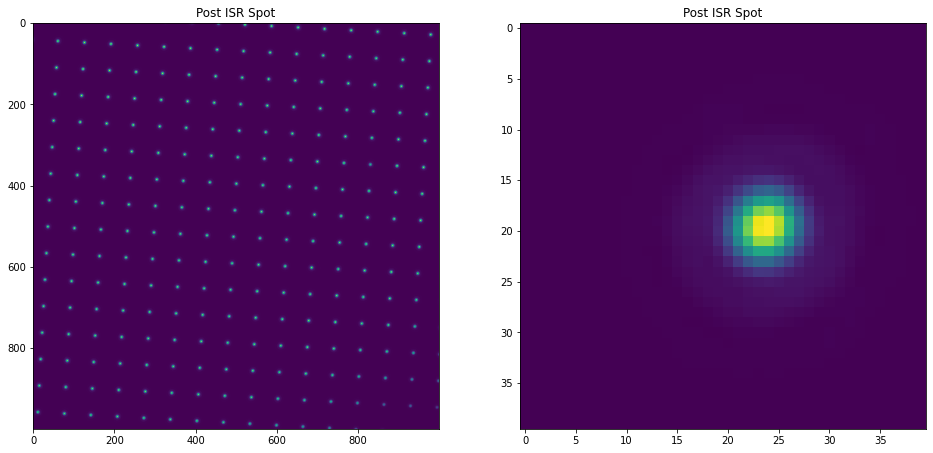

In [12]:
# Now just look at a portion of the images
plt.figure(figsize=(16,16))    
plt.subplot(1,2,1)
plt.title("Post ISR Spot")
plt.imshow(postIsrSpot.image.array[2000:3000,2000:3000])
plt.subplot(1,2,2)
plt.title("Post ISR Spot")
plt.imshow(postIsrSpot.image.array[2510:2550,2535:2575])


Detected  2281  objects 


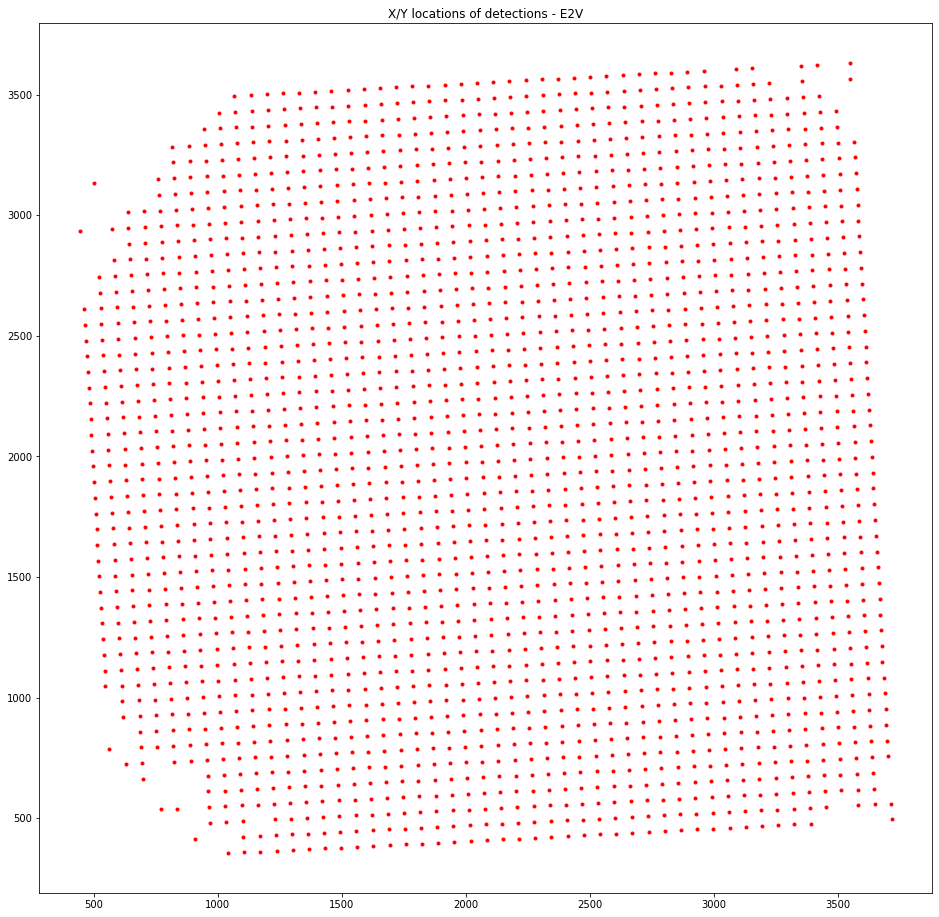

In [14]:
# Now let's try finding the spots
charConfig = CharacterizeImageConfig()
charConfig.installSimplePsf.fwhm = 1.0
charConfig.doMeasurePsf = False
charConfig.doApCorr = False
charConfig.doDeblend = False
charConfig.repair.doCosmicRay = True
charConfig.repair.doInterpolate = False   
charConfig.detection.background.binSize = 32
charConfig.detection.minPixels = 20
charTask = CharacterizeImageTask(config=charConfig)
charResult = charTask.run(postIsrSpot)

print("Detected ",len(charResult.sourceCat)," objects ")
plt.figure(figsize=(16,16))
plt.title('X/Y locations of detections - E2V')
plt.plot(charResult.sourceCat['base_SdssCentroid_x'],charResult.sourceCat['base_SdssCentroid_y'],'r.')
plt.savefig(REPO_DIR+'plots/Spot_Locations_28May20.pdf')